# 9-Qubit Error Correcting Code


#### In this notebook, we will show the functionality of the First Full Quantum Code.
#### We will refer back to the 3-Qubit Code, as the 9-Qubit Code is a repetition code.

In [30]:
import numpy as np

# Importing required libraries
from helpers.qec_helpers import *
from helpers.gates import *

from qiskit import QuantumRegister, ClassicalRegister, QuantumCircuit, Aer, execute
from qiskit.visualization import plot_histogram
from qiskit import user_config
from qiskit.quantum_info import partial_trace

import random
from qiskit.extensions import UnitaryGate



# Visualization of circuits: Initializing backend simulators
qasm_sim = Aer.get_backend('qasm_simulator')
sv_sim = Aer.get_backend('statevector_simulator')

# Setting mpl as default drawer
%env QISKIT_SETTINGS {}
user_config.set_config('circuit_drawer', 'mpl')



env: QISKIT_SETTINGS={}


## 3 Qubit Code Review

#### The 3 Qubit Code was shown to only be able to correct $\sigma_x$ (Bit-Flip) Errors
#### Only able to correct for one type of error at a time


### For $\sigma_z$ (Phase-Flip) Errors, does the error detection circuit signal an error?
#### We can build a circuit that detects phase-flip instead of bit-flip errors,
#### by instead encoding the qubits in a GHZ state in the $|±\rangle$ basis:
$\alpha|0\rangle + \beta|1\rangle \rightarrow \alpha|000\rangle + \beta|111\rangle \rightarrow \alpha|+ + +\rangle + 
\beta|− − −\rangle $



### Gate Operations Review ( CX and CZ ):



#### The CNOT gate is typically used to establish entanglement between qubits and implement controlled operations. 


#### CNOT gate matrix representation:  $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 0 & 1 \\
0 & 0 & 1 & 0
\end{pmatrix}$$


#### The CZ gate, also known as the HGZ gate, is a two-qubit gate that introduces a phase shift of $\pi$ to the qubit state. 
#### Phase Shift: Refers to a change in the timing or alignment of a wave or oscillation. 


#### The Z gate is represented by the following matrix: $$\begin{pmatrix}
1 & 0 & 0 & 0 \\
0 & 1 & 0 & 0 \\
0 & 0 & 1 & 0 \\
0 & 0 & 0 & -1
\end{pmatrix}$$



####  When applied to the $\vert0\rangle$ state, 
$$Z\vert0\rangle = \vert0\rangle$$

#### However, when applied to the $\vert1\rangle$ state, the Z gate introduces a phase shift of $\pi$ (or a phase flip) to the state.  
$$Z\vert1\rangle = -\vert1\rangle$$





### Foundations of Correction

#### This algorithm a single logical qubit,  encoded using 9 physical qubits.
#### Able to correct for both a single $\sigma_x$ error per block of 3 Qubits (bit flip) 
#### and for a $\sigma_z$ (phase-flip). 

#### In this case we will define our two logical states as $\vert0\rangle_L$ and $\vert1\rangle_L$ where $|0\rangle_L = \frac{1}{\sqrt{8}} \left( |000\rangle + |111\rangle \right) \left( |000\rangle + |111\rangle \right) \left( |000\rangle + |111\rangle \right)$ and
$|1\rangle_L = \frac{1}{\sqrt{8}} \left( |000\rangle - |111\rangle \right) \left( |000\rangle - |111\rangle \right) \left( |000\rangle - |111\rangle \right)$ and $\vert1\rangle_L = \vert111\rangle$

#### A single qubit state is still represented by $\vert\psi\rangle_L = \alpha\vert0\rangle_L + \beta\vert1\rangle_L$




#### Below we show the quantum circuit for encoding a single logical qubit in a 9-qubit system.

## Implementing for $\sigma_x$ correction: Logical state of a 9 Qubit Code

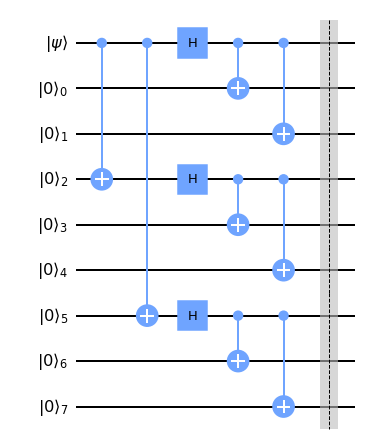

In [31]:

psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(8, '|0⟩')

qc = QuantumCircuit(psi, ancilla)
qc.cnot(0, 3)
qc.cnot(0, 6)
qc.h(0)
qc.h(3)
qc.h(6)
qc.cnot(0, 1)
qc.cnot(3, 4)
qc.cnot(6, 7)
qc.cnot(0, 2)
qc.cnot(3, 5)
qc.cnot(6, 8)
qc.barrier()

qc.draw()
 

    
 

In [37]:

def nine_qubit_initialize_logical_state(initial_psi):
    initial_ancilla_state = np.array([1, 0])
    psi = initial_psi

    # Initializing the logical state with 8 ancillas
    initial_logical_state = np.kron(psi, np.kron(initial_ancilla_state, np.kron(initial_ancilla_state, np.kron(
        initial_ancilla_state, np.kron(initial_ancilla_state, np.kron(initial_ancilla_state, np.kron(
            initial_ancilla_state,np.kron(initial_ancilla_state, initial_ancilla_state))))))))


    np.shape(initial_logical_state)

    # First two non-adjacent qubits on the left
    current_state = np.dot(CNOT(0, 3, 9), initial_logical_state)
    current_state = np.dot(CNOT(0, 6, 9), current_state)

    # All three Hadamard gates
    hadamards = np.kron(hadamard, np.kron(np.identity(2**2), np.kron(hadamard, np.kron(
        np.identity(2**2), np.kron(hadamard, np.identity(2**2))))))

    current_state = np.dot(hadamards, current_state)

    # The three adjacent qubits                                                                       
    current_state = np.dot(CNOT(0, 1, 9), current_state)
    current_state = np.dot(CNOT(3, 4, 9), current_state)
    current_state = np.dot(CNOT(6, 7, 9) , current_state)

    # Last three qubits
    current_state = np.dot(CNOT(0, 2, 9) , current_state)
    current_state = np.dot(CNOT(3, 5, 9) , current_state)
    current_state = np.dot(CNOT(6, 8, 9) , current_state)

    final_logical_state = np.kron(current_state, np.kron(np.array([1, 0]), np.array([1,0])))

    k = 9
    bit_representation = vector_state_to_bit_state(final_logical_state, k)[0]
    
    return final_logical_state

# Example usage
initial_psi = np.array([0, 1])
state = nine_qubit_initialize_logical_state(initial_psi)
print_state_info(state, 9)

000000000 :  0.3535533905932737
000000111 :  -0.3535533905932737
000111000 :  -0.3535533905932737
000111111 :  0.3535533905932737
111000000 :  -0.3535533905932737
111000111 :  0.3535533905932737
111111000 :  0.3535533905932737
111111111 :  -0.3535533905932737


## Initializing for our Phase Correction

### 9 Qubit Phase Flip Error Detection & Correction




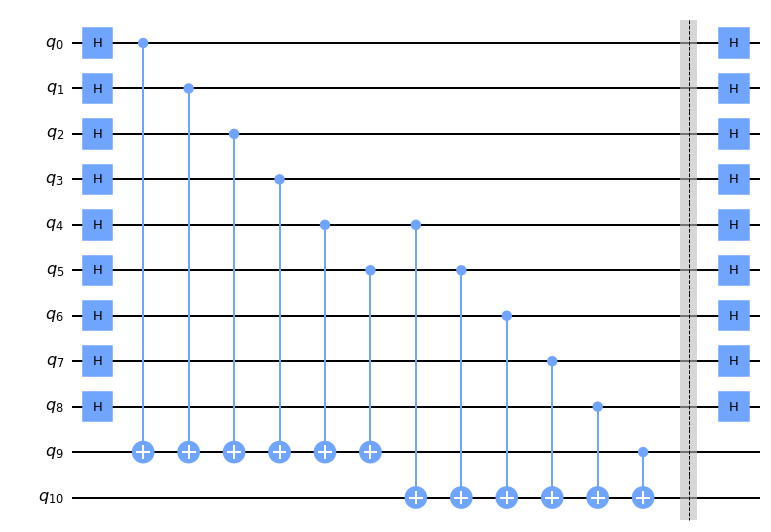

In [33]:
psi = QuantumRegister(1, '|ψ⟩')
ancilla = QuantumRegister(8, '|0⟩')
additional_ancilla = QuantumRegister(10, '|0⟩')
qc = QuantumCircuit(11)

# Hadamard gates on the left side (vertical arrangement)
for i in range(9):
    qc.h(i)

# Define the Z error correction circuit for Shor's code
qc.cx(0, 9)
qc.cx(1, 9)
qc.cx(2, 9)
qc.cx(3, 9)
qc.cx(4, 9)
qc.cx(5, 9)

qc.cx(4, 10)
qc.cx(5, 10)
qc.cx(6, 10)
qc.cx(7, 10)
qc.cx(8, 10)
qc.cx(9, 10)

# Add barrier gate after the error correction circuit
qc.barrier()

# Hadamard gates on the right side (vertical arrangement)
for i in range(9):
    qc.h(i)
qc.draw()



In [38]:
# adding in ancilla qubits
zero = np.array([1, 0])
vector_state = np.kron(state, np.kron(zero, zero))
print_state_info(vector_state, 11)

00000000000 :  0.3535533905932737
00000011100 :  -0.3535533905932737
00011100000 :  -0.3535533905932737
00011111100 :  0.3535533905932737
11100000000 :  -0.3535533905932737
11100011100 :  0.3535533905932737
11111100000 :  0.3535533905932737
11111111100 :  -0.3535533905932737


In [42]:
def detect_phase_flip(logical_state):
    # logical_state: the full vector state representation of your 11 qubit system (9 data, 2 ancilla)
                                                 
     # First Nine Hadamard gates
    hadamards = np.kron(hadamard, np.kron(hadamard, np.kron(hadamard, np.kron(
       hadamard, np.kron(hadamard, np.kron(hadamard, np.kron(
       hadamard, np.kron(hadamard, np.kron(hadamard, np.identity(2**2))))))))))

    current_state = np.dot(hadamards, logical_state)                                            
                                                 
                                                 
    # First Set of 6 CNOTS (We use two sets to detect sign differences)
    current_state = np.dot(CNOT(0, 9, 11), current_state)
    current_state = np.dot(CNOT(1, 9, 11), current_state)
    current_state = np.dot(CNOT(2, 9, 11), current_state)
    current_state = np.dot(CNOT(3, 9, 11), current_state)
    current_state = np.dot(CNOT(4, 9, 11), current_state)
    current_state = np.dot(CNOT(5, 9, 11), current_state)
                        
                        
    # Second Set of 6 CNOTS 
    current_state = np.dot(CNOT(3, 10, 11), current_state)
    current_state = np.dot(CNOT(4, 10, 11), current_state)
    current_state = np.dot(CNOT(5, 10, 11), current_state)
    current_state = np.dot(CNOT(6, 10, 11), current_state)
    current_state = np.dot(CNOT(7, 10, 11), current_state)
    current_state = np.dot(CNOT(8, 10, 11), current_state)
    
                        
    # Hadamards applied to each qubit on the right
    final_state = np.dot(hadamards, current_state) 
    final_state[np.abs(final_state) < 1e-15] = 0
    return final_state

# Example usage
final_state = detect_phase_flip(state)

print_state_info(final_state, 11)


00000000000 :  0.3535533905932731
00000011100 :  -0.3535533905932731
00011100000 :  -0.3535533905932731
00011111100 :  0.3535533905932731
11100000000 :  -0.3535533905932731
11100011100 :  0.3535533905932731
11111100000 :  0.3535533905932731
11111111100 :  -0.3535533905932731


## Concatenating Phase and Bit-Flip Error Correction

In [6]:
import random

def apply_pauli_X(qubit_index, num_qubits):
    pauli_X_matrix = np.array([[0, 1], [1, 0]])
    gate = np.identity(2)
    for _ in range(num_qubits - 1):
        gate = np.kron(gate, np.identity(2))
    gate[qubit_index][qubit_index] = pauli_X_matrix[0][0]
    gate[qubit_index][qubit_index + 1] = pauli_X_matrix[0][1]
    gate[qubit_index + 1][qubit_index] = pauli_X_matrix[1][0]
    gate[qubit_index + 1][qubit_index + 1] = pauli_X_matrix[1][1]
    return gate

def apply_pauli_Z(qubit_index, num_qubits):
    pauli_Z_matrix = np.array([[1, 0], [0, -1]])
    gate = np.identity(2)
    for _ in range(num_qubits - 1):
        gate = np.kron(gate, np.identity(2))
    gate[qubit_index][qubit_index] = pauli_Z_matrix[0][0]
    gate[qubit_index][qubit_index + 1] = pauli_Z_matrix[0][1]
    gate[qubit_index + 1][qubit_index] = pauli_Z_matrix[1][0]
    gate[qubit_index + 1][qubit_index + 1] = pauli_Z_matrix[1][1]
    return gate

def apply_random_x_error(logical_state):
    error_index = random.randint(0, 8)
    error_state = np.copy(logical_state)
    error_state[error_index] = 1 - error_state[error_index]
    return error_state, error_index

def apply_defined_x_error(logical_state, error_index):
    error_state = np.copy(logical_state)
    error_state[error_index] = 1 - error_state[error_index]
    return error_state, error_index

def apply_random_z_error(logical_state):
    error_index = random.randint(0, 8)
    error_state = np.copy(logical_state)
    error_state[error_index] *= -1
    return error_state, error_index

def apply_defined_z_error(logical_state, error_index):
    error_state = np.copy(logical_state)
    error_state[error_index] *= -1
    return error_state, error_index

# Example
logical_state = np.zeros(2 ** 9)
logical_state[0] = 1  # Initialize the logical state to |0...0>

# Generate multiple random X and Z errors
num_errors = 5

for i in range(num_errors):
    print(f"--- Error {i+1} ---")

    # Apply random X error to one of the qubits
    errored_state, error_qubit = apply_random_x_error(logical_state)
    print('Logical State without the random X error:', logical_state.astype(int))
    print('Logical State with the random X error:', errored_state.astype(int))
    print('The error occurred at qubit:', error_qubit)
    print()

    # Apply random Z error to one of the qubits
    errored_state, error_qubit = apply_random_z_error(logical_state)
    print('Logical State without the random Z error:', logical_state.astype(int))
    print('Logical State with the random Z error:', errored_state.astype(int))
    print('The error occurred at qubit:', error_qubit)
    print()

    # Apply defined X error to one of the qubits
    error_index = 4
    errored_state, error_qubit = apply_defined_x_error(logical_state, error_index)
    print('Logical State without the defined X error:', logical_state.astype(int))
    print('Logical State with the defined X error:', errored_state.astype(int))
    print('The error occurred at qubit:', error_qubit)
    print()

    # Apply defined Z error to one of the qubits
    error_index = 7
    errored_state, error_qubit = apply_defined_z_error(logical_state, error_index)
    print('Logical State without the defined Z error:', logical_state.astype(int))
    print('Logical State with the defined Z error:', errored_state.astype(int))
    print('The error occurred at qubit:', error_qubit)
    print()

    print()


--- Error 1 ---
Logical State without the random X error: [1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0

## Degeneracy in Error Correction
#### Regardless of what qubit is affected, the procedure will correct without a one-to-one correspondence

In [7]:
def initialize_error_correction(initial_psi):
    # Concatenated error correction initialization
    # Combines bit flip and phase flip error correction procedures

    # Bit flip error correction
    cnot_qubits_first_ancilla = [4, 5, 6, 7, 8, 9]
    bit_flip_ancilla = np.zeros(2 ** 8)
    for i in range(6):
        control = cnot_qubits_first_ancilla[i]
        bit_flip_ancilla = np.dot(
            np.kron(np.eye(2 ** (control - 1)), np.kron(cnot, np.eye(2 ** (7 - control)))), bit_flip_ancilla
        )
    # This loop performs the error correction procedure for bit flip errors
    # It applies controlled-not (CNOT) gates between the qubits and the ancilla qubits

    # Phase flip error correction
    cnot_qubits_second_ancilla = [1, 2, 3, 4, 5, 6]
    phase_flip_psi = initial_psi.copy()
    phase_flip_ancilla = np.zeros(2 ** 10)
    for i in range(9):
        phase_flip_psi = np.dot(np.kron(np.eye(2 ** i), hadamard), phase_flip_psi)
    for i in range(6):
        control = cnot_qubits_second_ancilla[i]
        phase_flip_ancilla = np.dot(
            np.kron(np.eye(2 ** (control - 1)), np.kron(cnot, np.eye(2 ** (5 - control)))), phase_flip_ancilla
        )
    for i in range(9):
        phase_flip_psi = np.dot(np.kron(np.eye(2 ** (8 - i)), hadamard), phase_flip_psi)
    # These loops perform the error correction procedure for phase flip errors
    # They apply Hadamard gates and CNOT gates to the qubits and ancilla qubits

    return bit_flip_ancilla, phase_flip_psi, phase_flip_ancilla


# Example usage
initial_psi = np.array([0, 1])
bit_flip_ancilla, phase_flip_psi, phase_flip_ancilla = initialize_error_correction(initial_psi)
k = 9  # Number of qubits in the reduced system (logical qubits)

bit_representation, reduced_logical_state = vector_state_to_bit_state(phase_flip_psi, k)

print('Bit Flip Ancilla:', bit_flip_ancilla)
print('Phase Flip Psi:', phase_flip_psi)
print('Phase Flip Ancilla:', phase_flip_ancilla)
print('Bit Representation:', bit_representation)
print('Reduced Logical State (Logical Qubits):', reduced_logical_state)


NameError: name 'cnot' is not defined

In [ ]:
Framework Behind Degenerate Code: The Bacon- Shor Coe

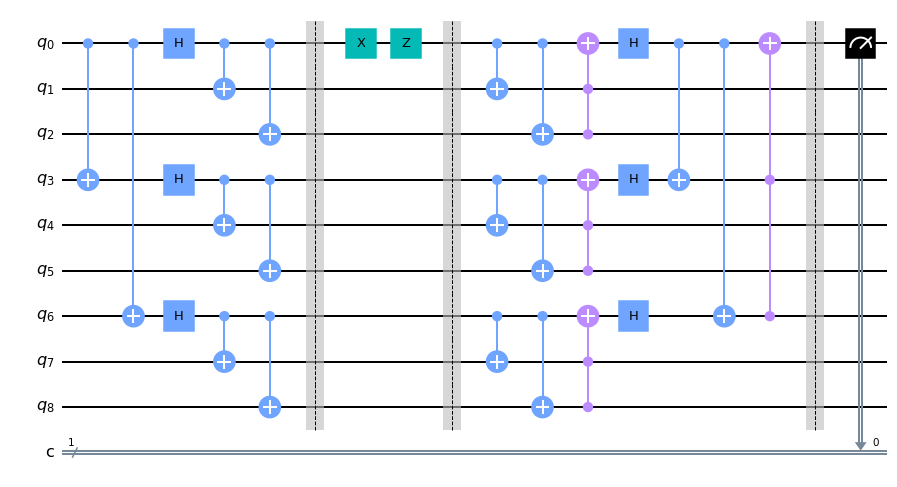

In [7]:
#####Shor code starts here ########
q = QuantumRegister(9,'q')
c = ClassicalRegister(1,'c')

circuit = QuantumCircuit(q,c)

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.barrier(q)

####error here############
circuit.x(q[0])#Bit flip error
#circuit.x(q[5])#Bit flip error
#circuit.x(q[8])#Bit flip error
circuit.z(q[0])#Phase flip error
############################

circuit.barrier(q)
circuit.cx(q[0],q[1])
circuit.cx(q[3],q[4])
circuit.cx(q[6],q[7])

circuit.cx(q[0],q[2])
circuit.cx(q[3],q[5])
circuit.cx(q[6],q[8])

circuit.ccx(q[1],q[2],q[0])
circuit.ccx(q[4],q[5],q[3])
circuit.ccx(q[8],q[7],q[6])

circuit.h(q[0])
circuit.h(q[3])
circuit.h(q[6])

circuit.cx(q[0],q[3])
circuit.cx(q[0],q[6])
circuit.ccx(q[6],q[3],q[0])

circuit.barrier(q)

circuit.measure(q[0],c[0])

circuit.draw()